# Model-Based Prediction (Dynamics)

Learning a dynamics model while using perfect reward and action-value functions in the MAAC($K$) estimator.

In [1]:
%matplotlib inline
import functools
import os
from typing import Callable, Iterable, Sequence, Union

import matplotlib
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
from lqsvg import analysis, data, estimator
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.experiment import plot
from lqsvg.experiment.utils import wandb_runs_dataframe
from lqsvg.random import make_rng
from lqsvg.torch import utils as ut
from lqsvg.torch.nn.value import QuadQValue
from matplotlib import pyplot as plt
from torch import Tensor, autograd, nn

from model_based_prediction import DataModule, DataSpec, Experiment, make_modules

sns.set()

/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


## On-policy

In [2]:
ON_POLICY_PREDICTION = wandb_runs_dataframe(
    "angelovtt/ch5", 
    configs={
        "exploration.type": None, "model.type": "linear",
    },
    tags=["ModelBasedPrediction"],
)
ON_POLICY_PREDICTION.head()

,val/8/relative_value_err,trainer/global_step,val/0/relative_value_err,_step,val/empirical_kl,val/4/relative_vval_err,_runtime,val/0/relative_vval_err,val/loss,val/2/relative_vval_err,...,summary/grad_2.0_norm_model.params.pre_diag_epoch,summary/test/2/relative_value_err,summary/val/0/grad_acc,summary/stability,summary/grad_2.0_norm_model.f_epoch,summary/test/2/grad_acc,summary/test/0/relative_vval_err,summary/grad_2.0_norm_model.params.pre_diag_step,summary/test/8/grad_acc,summary/val/4/grad_acc
0,1.549375,0,0.488652,0,6.451121,1.996451,11,0.0,4.448441,0.939066,...,0.084046,0.488389,0.72405,True,0.034708,0.71187,3.242493e-09,0.0019,0.67856,0.696482
1,NaN,49,NaN,1,NaN,NaN,12,NaN,NaN,NaN,...,0.084046,0.488389,0.72405,True,0.034708,0.71187,3.242493e-09,0.0019,0.67856,0.696482
2,NaN,99,NaN,2,NaN,NaN,13,NaN,NaN,NaN,...,0.084046,0.488389,0.72405,True,0.034708,0.71187,3.242493e-09,0.0019,0.67856,0.696482
3,NaN,149,NaN,3,NaN,NaN,14,NaN,NaN,NaN,...,0.084046,0.488389,0.72405,True,0.034708,0.71187,3.242493e-09,0.0019,0.67856,0.696482
4,NaN,199,NaN,4,NaN,NaN,14,NaN,NaN,NaN,...,0.084046,0.488389,0.72405,True,0.034708,0.71187,3.242493e-09,0.0019,0.67856,0.696482


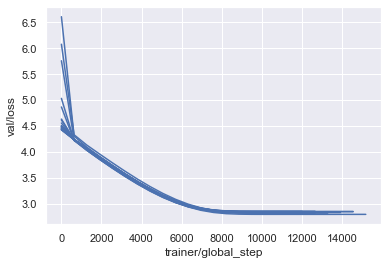

In [3]:
sns.lineplot(
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/loss",
    ci="sd",
    estimator=None,
    units="config/seed",
)
plt.show()

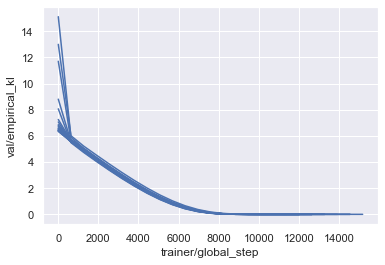

In [4]:
sns.lineplot(
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/empirical_kl",
    ci="sd",
    estimator=None,
    units="config/seed",
)
plt.show()

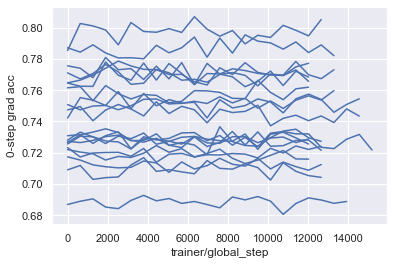

In [5]:
ax = sns.lineplot(
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/0/grad_acc",
    estimator=None,
    units="config/seed",
)
ax.set_ylabel("0-step grad acc")
plt.show()

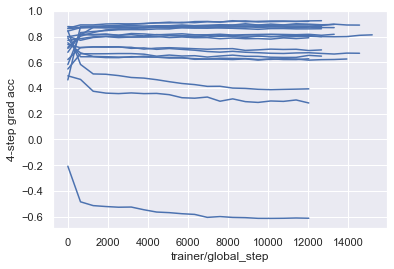

In [6]:
ax = sns.lineplot(
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/4/grad_acc",
    ci="sd",
    estimator=None,
    units="config/seed",
)
ax.set_ylabel("4-step grad acc")
plt.show()

In [7]:
ON_POLICY_PREDICTION["4-step improvement"] = ON_POLICY_PREDICTION["val/4/grad_acc"] - ON_POLICY_PREDICTION["val/0/grad_acc"]

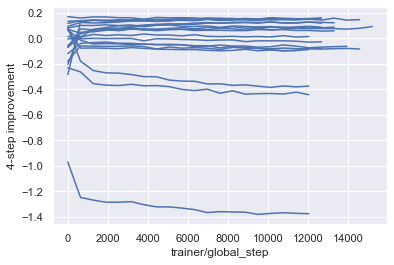

In [8]:
ax = sns.lineplot(
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="4-step improvement",
    ci="sd",
    estimator=None,
    units="config/seed",
)
plt.show()

### Training

In [9]:
config = {
    "wandb": {"name": "Debug", "mode": "offline"},
    "exploration": {"type": None},
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "seed": 124,
    "env_config": {
        "n_state": 2,
        "n_ctrl": 2,
        "horizon": 50,
        "passive_eigval_range": (0.9, 1.1),
    },
    "model": {"type": "linear"},
    "pred_horizon": 4,
    "zero_q": False,
    "datamodule": {
        "trajectories": 2000,
        "train_batch_size": 128,
        "val_loss_batch_size": 128,
        "val_grad_batch_size": 256,
        "seq_len": 4,
    },
    "trainer": dict(
        max_epochs=50,
        weights_summary="full",
    ),
}

#### Generate LQG
$p^*(s, a) = \mathcal{N}(\mathbf{F}_s s + \mathbf{F}_a a, \mathbf{\Sigma})$

$R(s, a) = - \tfrac{1}{2} [s, a]^\intercal\mathbf{C}[s, a] + \mathbf{c}^\intercal [s, a]$

In [10]:
rng = make_rng(config["seed"])
lqg, policy, _, model = make_modules(rng, config)

In [11]:
lqg.trans.standard_form().F.select("H", 0)

tensor([[ 1.0689,  0.0089,  0.9776,  0.9827],
        [ 0.0089,  1.0637,  0.2107, -0.1850]], names=('R', 'C'))

In [12]:
lqg.reward.standard_form().C.select("H", 0)

tensor([[ 0.4530, -0.2178,  0.0000,  0.0000],
        [-0.2178,  3.5398,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.3662, -0.0420],
        [ 0.0000,  0.0000, -0.0420,  0.7659]], names=('R', 'C'))

In [13]:
torch.linalg.eigh(lqg.reward.standard_form().C.select("H", 0).rename(None))

torch.return_types.linalg_eigh(
eigenvalues=tensor([0.4377, 0.7630, 1.3691, 3.5550]),
eigenvectors=tensor([[-0.9975, -0.0000,  0.0000, -0.0700],
        [-0.0700, -0.0000,  0.0000,  0.9975],
        [-0.0000, -0.0694, -0.9976,  0.0000],
        [-0.0000, -0.9976,  0.0694,  0.0000]]))

#### Collect & Fit

$\{ s_i, a_i, s_i' \}_{i=1}^{N} \sim \mu_\theta$

$\psi' \gets \arg\min_{\psi} -\tfrac{1}{N} \sum_{i=1}^{N} \log p_{\psi}(s_i'|s_i, a_i)$

In [14]:
SAVE_PATH = "state_dict124.pt"

datamodule = DataModule(lqg, policy, DataSpec(**config["datamodule"]), rng.torch)
trainer = pl.Trainer(
    default_root_dir=None,
    logger=False,
    callbacks=[pl.callbacks.EarlyStopping("val/loss")],
    num_sanity_val_steps=0,
    checkpoint_callback=False,
    **config["trainer"],
)

trainer.validate(model, datamodule=datamodule)
if os.path.exists(SAVE_PATH):
    model.model.load_state_dict(torch.load(SAVE_PATH))
else:
    trainer.fit(model, datamodule=datamodule)
    torch.save(model.model.state_dict(), SAVE_PATH)
final_eval = trainer.test(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWar

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val/4/grad_acc': -0.03134893998503685,
 'val/4/relative_value_err': 0.037125080823898315,
 'val/4/relative_vval_err': 0.8585314750671387,
 'val/empirical_kl': 6.684424877166748,
 'val/loss': 4.490170955657959}
--------------------------------------------------------------------------------
DATALOADER:1 VALIDATE RESULTS
{'val/4/grad_acc': -0.03134893998503685,
 'val/4/relative_value_err': 0.037125080823898315,
 'val/4/relative_vval_err': 0.8585314750671387,
 'val/empirical_kl': 6.684424877166748,
 'val/loss': 4.490170955657959}
--------------------------------------------------------------------------------


/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/angelolovatto/Library/Caches/pypoetry/virtualenvs/lqsvg-G_e_Olvw-py3.8/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 1, does not have many workers which may be a bottleneck. Consider incre

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test/4/grad_acc': -0.809055507183075,
 'test/4/relative_value_err': 0.4738820195198059,
 'test/4/relative_vval_err': 0.010244113393127918,
 'test/empirical_kl': 0.000999296666122973,
 'test/loss': 2.8321824073791504}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'test/4/grad_acc': -0.809055507183075,
 'test/4/relative_value_err': 0.4738820195198059,
 'test/4/relative_vval_err': 0.010244113393127918,
 'test/empirical_kl': 0.000999296666122973,
 'test/loss': 2.8321824073791504}
--------------------------------------------------------------------------------


### Get the validation data

In [15]:
_, val_loader = datamodule.val_dataloader()

In [16]:
(obs,) = next(iter(val_loader))

In [17]:
obs = obs.refine_names("B", "R")

### Get the true value and SVG

In [18]:
val, svg = model.true_val, lqr.Linear(model.true_svg_K, model.true_svg_k)

In [19]:
val

tensor(-322.6437, grad_fn=<NegBackward>)

In [20]:
svg.K[0], svg.k[0]

(tensor([[ 0.8923, -1.0159],
         [ 0.5689,  1.1825]]),
 tensor([0., 0.]))

### Evaluate MAAC(K) with the true model

In [21]:
maac_true = estimator.maac_estimator(
    policy,
    data.markovian_state_sampler(lqg.trans, lqg.trans.rsample),
    lqg.reward,
    QuadQValue.from_policy(
        policy.standard_form(), lqg.trans.standard_form(), lqg.reward.standard_form()
    ),
)

In [22]:
mc_val, mc_svg = maac_true(obs, 4)

In [23]:
mc_val

tensor(-156.2083, grad_fn=<MeanBackward0>)

In [24]:
mc_svg.K[0]

tensor([[-0.0068, -0.0986],
        [ 0.0441,  0.1133]])

In [25]:
print(analysis.cosine_similarity(svg, mc_svg))

tensor(0.8970)


### Evaluate MAAC(K) with the learned model

In [26]:
for k in range(8):
    print(analysis.cosine_similarity(svg, model.estimator(obs, k)[1]))

tensor(0.7637)
tensor(-0.5037)
tensor(-0.6798)
tensor(-0.7623)
tensor(-0.7951)
tensor(-0.8160)
tensor(-0.8359)
tensor(-0.8132)


### Compare model predictions

In [27]:
def obs_only(sampler: data.StateDynamics) -> Callable[[Tensor, Tensor], Tensor]:
    """Removes the likelihood return from a transition function."""

    def sample_(obs: Tensor, act: Tensor) -> Tensor:
        return sampler(obs, act)[0].rename(None)

    return sample_

In [28]:
state_action_dynamics = obs_only(
    data.markovian_state_sampler(lqg.trans, lqg.trans.rsample)
)
state_action_model = obs_only(
    data.markovian_state_sampler(model.model, model.model.dist.rsample)
)

In [29]:
def state_dynamics(obs: Tensor) -> Tensor:
    return state_action_dynamics(obs, policy(obs))


def state_model(obs: Tensor) -> Tensor:
    return state_action_model(obs, policy(obs))

In [30]:
def state_mean_dynamics(obs: Tensor) -> Tensor:
    return lqg.trans(obs, policy(obs))["loc"]


def state_mean_model(obs: Tensor) -> Tensor:
    return model.model(obs, policy(obs))["loc"]

In [31]:
nn.MSELoss()(state_mean_dynamics(obs).rename(None), state_mean_model(obs).rename(None))

tensor(7.6216e-05, grad_fn=<MseLossBackward>)

### Compare model Jacobians

In [32]:
true_jacobian = torch.cat(
    autograd.functional.jacobian(
        state_action_dynamics, (obs.select("B", 0), policy(obs.select("B", 0)))
    ),
    axis=-1,
)

In [33]:
print("State-action Jacobian:\n", true_jacobian)
print("Dynamics kernel:\n", lqg.trans.standard_form().F.select("H", 0))

State-action Jacobian:
 tensor([[ 1.0689,  0.0089,  0.0000,  0.9776,  0.9827],
        [ 0.0089,  1.0637,  0.0000,  0.2107, -0.1850],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
Dynamics kernel:
 tensor([[ 1.0689,  0.0089,  0.9776,  0.9827],
        [ 0.0089,  1.0637,  0.2107, -0.1850]], names=('R', 'C'))


In [34]:
model_jacobian = torch.cat(
    autograd.functional.jacobian(
        state_action_model,
        (obs.select("B", 0), policy(obs.select("B", 0))),
    ),
    axis=-1,
)

In [35]:
print("Model Jacobian:\n", model_jacobian)

Model Jacobian:
 tensor([[-0.1072, -0.0347,  0.0000, -0.0238,  0.0202],
        [ 0.0403,  0.3481,  0.0000, -0.2826,  0.3444],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


**Cosine similarity between rows/cols of the Jacobians**

In [36]:
for row in range(2):
    print("Row:", row)
    true_Ji = true_jacobian[row, :]
    model_Ji = model_jacobian[row, :]
    print(analysis.cosine_similarity(true_Ji, model_Ji))

Row: 0
tensor(-0.5780)
Row: 1
tensor(0.3968)


In [37]:
for col in (0, 1, 3, 4):
    print("Column:", col)
    true_Ji = true_jacobian[:, col]
    model_Ji = model_jacobian[:, col]
    print(analysis.cosine_similarity(true_Ji, model_Ji))

Column: 0
tensor(-0.9330)
Column: 1
tensor(0.9942)
Column: 3
tensor(-0.2921)
Column: 4
tensor(-0.1270)


**Inspecting the on-policy state transition Jacobians**

$$f^{\mu}(\mathbf{s}, \xi) = f(\mathbf{s}, \mu_\theta(\mathbf{s}), \xi)$$


$\nabla_\mathbf{s} f_*^\mu(\mathbf{s}, \xi)$

In [38]:
jac_state_dynamics = autograd.functional.jacobian(state_dynamics, obs.select("B", 0))
jac_state_dynamics

tensor([[-1.0490e-01, -3.9116e-08,  0.0000e+00],
        [ 6.5193e-09,  7.8521e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

 $\nabla_\mathbf{s} f_\psi^\mu(\mathbf{s}, \xi)$

In [39]:
jac_state_model = autograd.functional.jacobian(state_model, obs.select("B", 0))
jac_state_model

tensor([[-0.1057, -0.0037,  0.0000],
        [-0.0069,  0.7887,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

det$\left(\nabla_\mathbf{s} f_*^\mu(\mathbf{s}, \xi)\right)$

In [40]:
torch.linalg.det(jac_state_dynamics[:2, :2])

tensor(-0.0824)

det$\left(\nabla_\mathbf{s} f_\psi^\mu(\mathbf{s}, \xi)\right)$

In [41]:
torch.linalg.det(jac_state_model[:2, :2])

tensor(-0.0834)

$\left\| \nabla_\mathbf{s} f_\psi^\mu(\mathbf{s}, \xi) - \nabla_\mathbf{s} f_*^\mu(\mathbf{s}, \xi) \right\|$

In [42]:
torch.linalg.norm(jac_state_model[:2, :2] - jac_state_dynamics[:2, :2])

tensor(0.0086)

### Inspecting the optimization surface

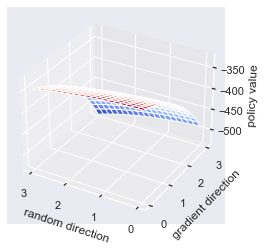

In [77]:
dynamics, cost, init = lqg.standard_form()
f_delta = analysis.delta_to_return(policy.standard_form(), dynamics, cost, init)
direction = ut.tensors_to_vector(model.estimator(obs, 4)[1])
X, Y, Z = analysis.optimization_surface(f_delta, direction.numpy(), rng=2985489)

ax = plot.plot_surface(X, Y, Z, invert_xaxis=True)
ax.set_xlabel("random direction")
ax.set_ylabel("gradient direction")
ax.set_zlabel("policy value")
plt.show()

## Off-policy

In [44]:
OFF_POLICY_PREDICTION = wandb_runs_dataframe(
    "angelovtt/ch5", 
    configs={
        "exploration.type": "gaussian", "model.type": "linear",
    },
    tags=["ModelBasedPrediction"],
)
OFF_POLICY_PREDICTION.head()

,val/8/relative_value_err,trainer/global_step,val/0/relative_value_err,_step,val/empirical_kl,val/4/relative_vval_err,_runtime,val/0/relative_vval_err,val/loss,val/2/relative_vval_err,...,summary/test/loss,summary/epoch,summary/test/8/relative_vval_err,summary/test/4/relative_value_err,summary/grad_2.0_norm_model.f_epoch,summary/val/2/grad_acc,summary/val/2/relative_value_err,summary/test/empirical_kl,summary/grad_2.0_norm_model.params.pre_diag_step,summary/test/0/relative_value_err
0,1.552304,0,0.486679,0,6.494331,1.988582,11,7.629395e-09,4.459242,0.936043,...,2.847651,19,0.007981,0.485192,0.034783,0.65625,0.48702,-0.001819,0.0017,0.486539
1,NaN,49,NaN,1,NaN,NaN,11,NaN,NaN,NaN,...,2.847651,19,0.007981,0.485192,0.034783,0.65625,0.48702,-0.001819,0.0017,0.486539
2,NaN,99,NaN,2,NaN,NaN,13,NaN,NaN,NaN,...,2.847651,19,0.007981,0.485192,0.034783,0.65625,0.48702,-0.001819,0.0017,0.486539
3,NaN,149,NaN,3,NaN,NaN,14,NaN,NaN,NaN,...,2.847651,19,0.007981,0.485192,0.034783,0.65625,0.48702,-0.001819,0.0017,0.486539
4,NaN,199,NaN,4,NaN,NaN,15,NaN,NaN,NaN,...,2.847651,19,0.007981,0.485192,0.034783,0.65625,0.48702,-0.001819,0.0017,0.486539


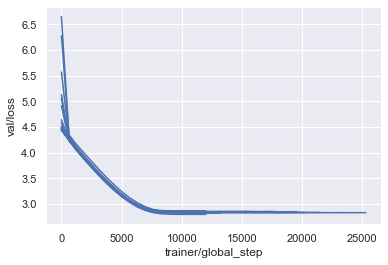

In [45]:
sns.lineplot(
    data=OFF_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/loss",
    ci="sd",
    estimator=None,
    units="config/seed",
)
plt.show()

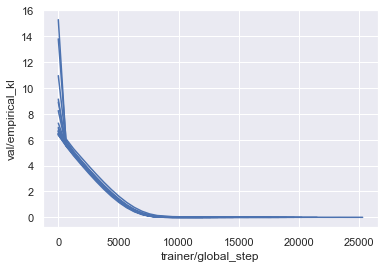

In [46]:
sns.lineplot(
    data=OFF_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/empirical_kl",
    ci="sd",
    estimator=None,
    units="config/seed",
)
plt.show()

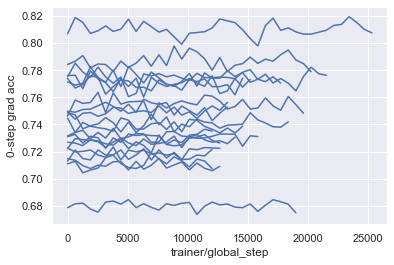

In [47]:
ax = sns.lineplot(
    data=OFF_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/0/grad_acc",
    ci="sd",
    estimator=None,
    units="config/seed",
)
ax.set_ylabel("0-step grad acc")
plt.show()

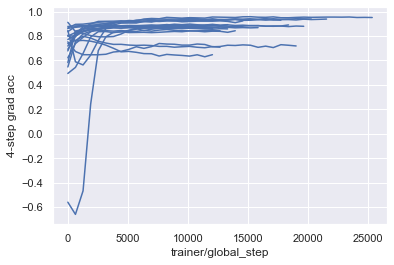

In [48]:
ax = sns.lineplot(
    data=OFF_POLICY_PREDICTION,
    x="trainer/global_step",
    y="val/4/grad_acc",
    ci="sd",
    estimator=None,
    units="config/seed",
)
ax.set_ylabel("4-step grad acc")
plt.show()

In [49]:
OFF_POLICY_PREDICTION["4-step improvement"] = OFF_POLICY_PREDICTION["val/4/grad_acc"] - OFF_POLICY_PREDICTION["val/0/grad_acc"]

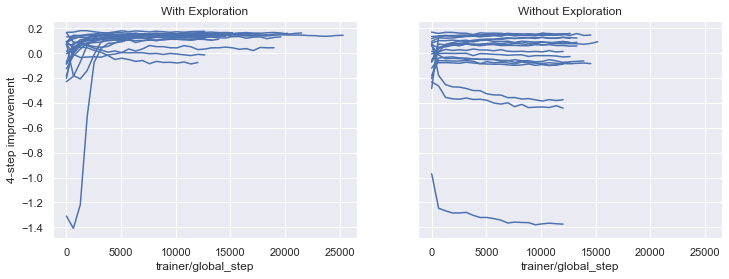

In [50]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=plot.default_figsize(1, 2))
sns.lineplot(
    ax=ax0,
    data=OFF_POLICY_PREDICTION,
    x="trainer/global_step",
    y="4-step improvement",
    ci="sd",
    estimator=None,
    units="config/seed",
)
ax0.set_title("With Exploration")

sns.lineplot(
    ax=ax1,
    data=ON_POLICY_PREDICTION,
    x="trainer/global_step",
    y="4-step improvement",
    ci="sd",
    estimator=None,
    units="config/seed",
)
ax1.set_title("Without Exploration")
plt.show()

# Model-Based Prediction (Reward)

Learning a reward function in isolation

**Metrics**
1. Mean-squared error: $\mathbb{E}\left[ \left( R(s, a) - R_\psi(s, a)\right)^2 \right]$
1. State gradient accuracy: cossim$(\nabla_{s} R(s, a), \nabla_{s} R_\psi(s, a))$
1. Action gradient accuracy: cossim$(\nabla_{a} R(s, a), \nabla_{a} R_\psi(s, a))$

In [52]:
REWARD_ONLY = wandb_runs_dataframe(
    "angelovtt/ch5",
    configs={},
    tags="9.30.0 RewardLearning".split()
)
REWARD_ONLY.head()

,trainer/global_step,_step,_runtime,val/loss,val/obs_grad_acc,epoch,val/act_grad_acc,_timestamp,train/act_grad_acc,train/loss,...,summary/test/loss,summary/trainable_parameters,summary/val/loss,summary/train/obs_grad_acc,summary/val/obs_grad_acc,summary/train/act_grad_acc,summary/test/obs_grad_acc,summary/controllability,summary/test/act_grad_acc,summary/epoch
0,0,0,4,89.433434,0.451624,0,0.967689,1633034874,NaN,NaN,...,0.00026,20,0.000247,0.999833,0.999856,0.999791,0.999844,True,0.999804,39
1,49,1,5,NaN,NaN,0,NaN,1633034875,0.973206,78.105156,...,0.00026,20,0.000247,0.999833,0.999856,0.999791,0.999844,True,0.999804,39
2,99,2,6,NaN,NaN,0,NaN,1633034876,0.974463,67.964920,...,0.00026,20,0.000247,0.999833,0.999856,0.999791,0.999844,True,0.999804,39
3,149,3,6,NaN,NaN,0,NaN,1633034876,0.978202,51.290260,...,0.00026,20,0.000247,0.999833,0.999856,0.999791,0.999844,True,0.999804,39
4,199,4,7,NaN,NaN,0,NaN,1633034877,0.961897,51.479877,...,0.00026,20,0.000247,0.999833,0.999856,0.999791,0.999844,True,0.999804,39


In [53]:
REWARD_ONLY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9984 entries, 0 to 9983
Data columns (total 45 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   trainer/global_step                       9984 non-null   int64  
 1   _step                                     9984 non-null   int64  
 2   _runtime                                  9984 non-null   int64  
 3   val/loss                                  1255 non-null   float64
 4   val/obs_grad_acc                          1255 non-null   float64
 5   epoch                                     9984 non-null   int64  
 6   val/act_grad_acc                          1255 non-null   float64
 7   _timestamp                                9984 non-null   int64  
 8   train/act_grad_acc                        8714 non-null   float64
 9   train/loss                                8714 non-null   float64
 10  train/obs_grad_acc                  

**validation mean-squared error**

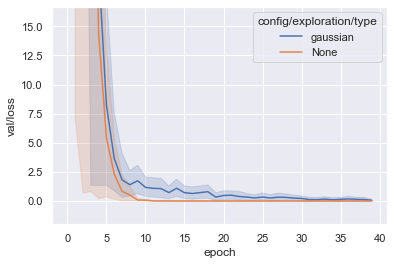

In [74]:
ax = sns.lineplot(
    data=REWARD_ONLY,
    x="epoch",
    y="val/loss",
    hue="config/exploration/type",
)
ax.set_ylim(ymin=-2, ymax=np.nanpercentile(REWARD_ONLY["val/loss"], 95))
plt.show()

**state gradient accuracy**

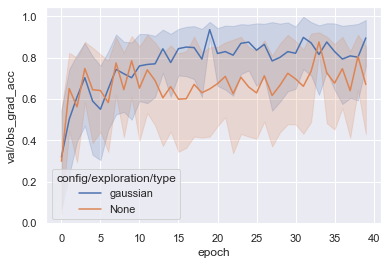

In [75]:
sns.lineplot(
    data=REWARD_ONLY,
    x="epoch",
    y="val/obs_grad_acc",
    hue="config/exploration/type",
#     units="config/seed",
#     estimator=None,
)
plt.show()

**action gradient accuracy**

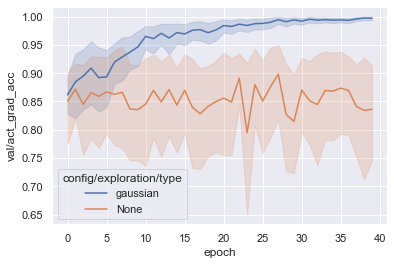

In [76]:
sns.lineplot(
    data=REWARD_ONLY,
    x="epoch",
    y="val/act_grad_acc",
    hue="config/exploration/type",
)
plt.show()